In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Project - C147/project/

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1-ZqOst-RT6vlWrAPZPiqbkETxbuIXYY1/Project - C147/project


In [ ]:
import numpy as np
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

y_train_valid -= 769
y_test -= 769

## Data Prep

In [ ]:
def train_data_prep(X,y,sub_sample,average,noise):

    total_X = None
    total_y = None

    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample) - resultant vec has 400 points - downsampling; performing low pass filtering on EEG signals
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)


    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)

    # Averaging + noise
    #first: mean pooling - downsampling method; smoothing
    #second: add Gaussian noise; regularizing effect
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)

    total_X = np.vstack((total_X, X_average)) #vertical stacking; 4230 samples after stacking; size of dataset increased; each of dimension 22x400
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)

    # Subsampling + noise addition

    for i in range(sub_sample):

        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)

        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))


    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    return total_X,total_y


def test_data_prep(X):

    total_X = None


    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 8), axis=3)


    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)

    return total_X

In [ ]:
#Proper splitting

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
# # Train Val split
# x_train, x_val, y_train, y_val = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=42)
ind_valid = np.random.choice(2115, 235, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid]
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]

x_train,y_train = train_data_prep(x_train,y_train,8,8,True)
x_valid,y_valid = train_data_prep(x_valid,y_valid,8,8,True)
print("Val prep shape=",x_valid.shape)
x_test = test_data_prep(X_test)

# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_valid.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)

# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)


Shape of X after trimming: (1880, 22, 800)
Shape of X after maxpooling: (1880, 22, 100)
Shape of X after averaging+noise and concatenating: (3760, 22, 100)
Shape of X after subsampling and concatenating: (18800, 22, 100)
Shape of Y: (18800,)
Shape of X after trimming: (235, 22, 800)
Shape of X after maxpooling: (235, 22, 100)
Shape of X after averaging+noise and concatenating: (470, 22, 100)
Shape of X after subsampling and concatenating: (2350, 22, 100)
Shape of Y: (2350,)
Val prep shape= (2350, 22, 100)
Shape of X after trimming: (443, 22, 800)
Shape of X after maxpooling: (443, 22, 100)
Shape of training labels after categorical conversion: (18800, 4)
Shape of validation labels after categorical conversion: (2350, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of training set after adding width info: (18800, 22, 100, 1)
Shape of validation set after adding width info: (2350, 22, 100, 1)
Shape of test set after adding width info: (443, 22, 100, 1)
Shape of train

## Model

In [ ]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape,Bidirectional,TimeDistributed
from keras.utils import to_categorical
import matplotlib.pyplot as plt

In [ ]:
# Building the CNN model using sequential class
hybrid_cnn_lstm_model = Sequential()
#created a 2D conv layer instead of one dimensional
# Conv. block 1
hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(5,5), padding='same', activation='elu', input_shape=(100,1,22)))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# Conv. block 2
hybrid_cnn_lstm_model.add(Conv2D(filters=50, kernel_size=(5,5), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# Conv. block 3
hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(5,5), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# Conv. block 4
hybrid_cnn_lstm_model.add(Conv2D(filters=200, kernel_size=(5,5), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# Reshape output to fit LSTM input shape
hybrid_cnn_lstm_model.add(Reshape((200, -1)))
# LSTM layer
hybrid_cnn_lstm_model.add(Bidirectional(LSTM(64, return_sequences=False)))

# hybrid_cnn_lstm_model.add(Flatten())

# Output layer with Softmax activation
hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
hybrid_cnn_lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 100, 1, 100)       55100     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 34, 1, 100)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_12 (Ba  (None, 34, 1, 100)        400       
 tchNormalization)                                               
                                                                 
 dropout_12 (Dropout)        (None, 34, 1, 100)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 34, 1, 50)         125050    
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 12, 1, 50)        

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


# Model parameters
learningrate = 1e-3
epochs = 100
hybrid_cnn_lstm_optimizer = Adam(learning_rate=learningrate)
# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

In [ ]:
# Compiling the model
hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy',
                 optimizer=hybrid_cnn_lstm_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
hybrid_cnn_lstm_model_results = hybrid_cnn_lstm_model.fit(x_train,
             y_train,
             batch_size=128,
             epochs=epochs,
                                                          validation_data=(x_valid, y_valid), verbose=True)
            #  validation_data=(x_valid, y_valid), verbose=True, callbacks=[early_stopping])




Epoch 1/100
147/147 [==============================] - 11s 33ms/step - loss: 1.3342 - accuracy: 0.3344 - val_loss: 1.3634 - val_accuracy: 0.3506
Epoch 2/100
147/147 [==============================] - 4s 24ms/step - loss: 1.2094 - accuracy: 0.4533 - val_loss: 1.1595 - val_accuracy: 0.4651
Epoch 3/100
147/147 [==============================] - 3s 23ms/step - loss: 1.1466 - accuracy: 0.4924 - val_loss: 1.1152 - val_accuracy: 0.5030
Epoch 4/100
147/147 [==============================] - 4s 29ms/step - loss: 1.1016 - accuracy: 0.5155 - val_loss: 1.1373 - val_accuracy: 0.4979
Epoch 5/100
147/147 [==============================] - 3s 23ms/step - loss: 1.0500 - accuracy: 0.5520 - val_loss: 1.0244 - val_accuracy: 0.5706
Epoch 6/100
147/147 [==============================] - 3s 23ms/step - loss: 1.0021 - accuracy: 0.5879 - val_loss: 0.9826 - val_accuracy: 0.5928
Epoch 7/100
147/147 [==============================] - 4s 25ms/step - loss: 0.9425 - accuracy: 0.6179 - val_loss: 0.9571 - val_accuracy

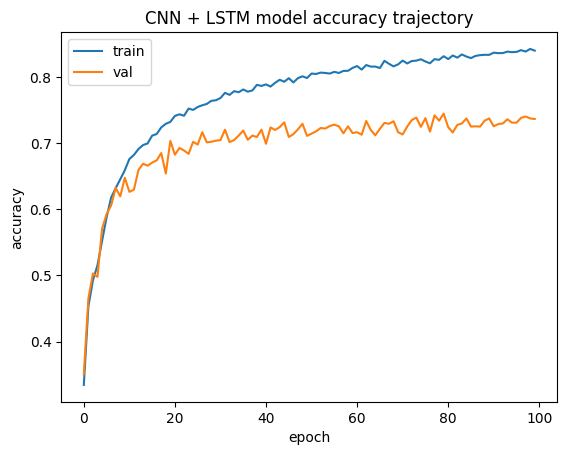

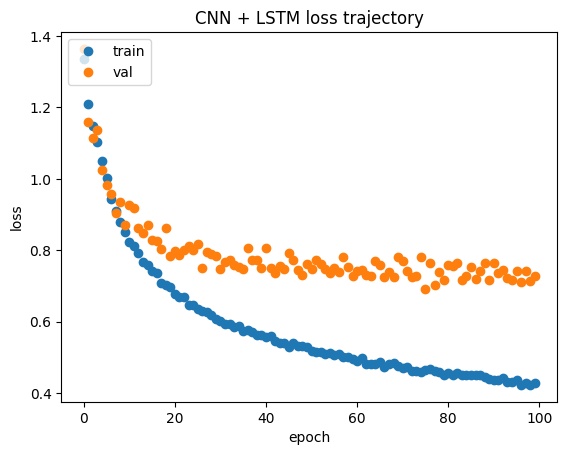

In [ ]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['accuracy'])
plt.plot(hybrid_cnn_lstm_model_results.history['val_accuracy'])
plt.title('CNN + LSTM model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['loss'],'o')
plt.plot(hybrid_cnn_lstm_model_results.history['val_loss'],'o')
plt.title('CNN + LSTM loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
hybrid_cnn_lstm_score = hybrid_cnn_lstm_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hybrid CNN+LSTM model:',hybrid_cnn_lstm_score[1])

Test accuracy of the hybrid CNN+LSTM model: 0.6794582605361938
